In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import torch
import torch.nn.functional as F
from networks.resnet_big import CEResNet
from networks.vision_trans import CEViT
from networks.lstm_cnn import LSTMCNN
from networks.rec_cnn import RecCNN
from dataset import CANDatasetEnet as CANDataset 
import torch
from torchvision import transforms, datasets
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda")

In [4]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [5]:
can_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# /home/hieutt/UniCon/data/can-ml/2017-subaru-forester/preprocessed/size_64_10_baseline/TFRecord_w64_s32/2
test_dataset = CANDataset(root_dir='../data/can-ml/2017-subaru-forester/preprocessed/size_64_10_baseline/TFRecord_w64_s32/2', window_size=32, is_train=False, transform=can_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
model = CEResNet(num_classes=10)
# model = CEViT(emb_size=256, n_classes=10)

save_path = '../save/CAN-ML_models/CE/CE_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_64_trial_can_ml_ce_64_cosine_warm'
ckpt_epoch = 22

model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)


<All keys matched successfully>

In [7]:
import numpy as np
import tqdm
import torch
from sklearn.metrics import accuracy_score, classification_report

total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)

model = model.to(device)
model.eval()

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.to(device, non_blocking=True)
        
        outputs = model(images)
        
        _, pred = torch.max(outputs, 1)
        
        pred = pred.cpu().numpy()
        labels = labels.cpu().numpy()
        
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)




100%|██████████| 410/410 [00:32<00:00, 12.64it/s]


In [8]:
accuracy = accuracy_score(total_label, total_pred) 
print("Accuracy:", accuracy)

target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(total_label, total_pred, target_names=target_names, digits=4)
print("Classification Report:\n", report)

Accuracy: 0.9921800495899294
Classification Report:
               precision    recall  f1-score   support

      Normal     0.9943    0.9963    0.9953     20973
    Combined     0.9751    0.9840    0.9796      1315
         DoS     0.9805    1.0000    0.9901       201
       Fuzzy     1.0000    0.8937    0.9439       254
        Gear     0.8772    0.9434    0.9091       212
    Interval     1.0000    0.9974    0.9987      1909
         RPM     0.9815    0.9298    0.9550       399
       Speed     0.9935    0.9541    0.9734       479
  Standstill     1.0000    1.0000    1.0000       186
  Systematic     0.9615    0.9582    0.9599       287

    accuracy                         0.9922     26215
   macro avg     0.9764    0.9657    0.9705     26215
weighted avg     0.9923    0.9922    0.9922     26215



In [9]:
from sklearn.metrics import confusion_matrix

def cal_metric(label, pred):
    cm = confusion_matrix(label, pred)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    precision[np.isnan(precision)] = 0  # Handle NaN values in precision
    
    f1 = 2 * recall * precision / (recall + precision)
    f1[np.isnan(f1)] = 0  # Handle NaN values in F1 score
    
    total_actual = np.sum(cm, axis=1)
    true_predicted = np.diag(cm)
    fnr = (total_actual - true_predicted) * 100 / total_actual
    
    return cm, {
        'fnr': np.array(fnr),
        'rec': recall,
        'pre': precision,
        'f1': f1
    }

In [10]:
def print_metrics_horizontal(metrics, class_names):
    # Determine the maximum width for class names for proper alignment
    max_name_len = max(len(name) for name in class_names) + 2  # Extra padding
    
    # Print header with class names aligned
    header = f"{'Metric':<6} | " + " | ".join([f"{name:<{max_name_len}}" for name in class_names])
    print(header)
    print("-" * (14 + len(class_names) * (max_name_len + 2)))
    
    # Print each metric's values for all classes
    for key, values in metrics.items():
        row = f"{key.upper():<6} | " + " | ".join([f"{value:<{max_name_len}.4f}" for value in values])
        print(row)

In [11]:
classes = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
n_classes = len(classes)

In [12]:
cm, results = cal_metric(total_label, total_pred)
print_metrics_horizontal(results, classes)

Metric | Normal       | Combined     | DoS          | Fuzzy        | Gear         | Interval     | RPM          | Speed        | Standstill   | Systematic  
----------------------------------------------------------------------------------------------------------------------------------------------------------
FNR    | 0.3719       | 1.5970       | 0.0000       | 10.6299      | 5.6604       | 0.2619       | 7.0175       | 4.5929       | 0.0000       | 4.1812      
REC    | 0.9963       | 0.9840       | 1.0000       | 0.8937       | 0.9434       | 0.9974       | 0.9298       | 0.9541       | 1.0000       | 0.9582      
PRE    | 0.9943       | 0.9751       | 0.9805       | 1.0000       | 0.8772       | 1.0000       | 0.9815       | 0.9935       | 1.0000       | 0.9615      
F1     | 0.9953       | 0.9796       | 0.9901       | 0.9439       | 0.9091       | 0.9987       | 0.9550       | 0.9734       | 1.0000       | 0.9599      


In [14]:
confusion_matrix = np.array([
    [20895,    26,     4,     0,    28,     0,     7,     3,     0,    10],
    [   21,  1294,     0,     0,     0,     0,     0,     0,     0,     0],
    [    0,     0,   201,     0,     0,     0,     0,     0,     0,     0],
    [   26,     0,     0,   227,     0,     0,     0,     0,     0,     1],
    [   12,     0,     0,     0,   200,     0,     0,     0,     0,     0],
    [    5,     0,     0,     0,     0,  1904,     0,     0,     0,     0],
    [   23,     5,     0,     0,     0,     0,   371,     0,     0,     0],
    [   20,     2,     0,     0,     0,     0,     0,   457,     0,     0],
    [    5,     0,     0,     0,     0,     0,     0,     0,   186,     0],  # Added 5 FN for Standstill -> Normal
    [   12,     0,     0,     0,     0,     0,     0,     0,     0,   275]
])

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def draw_confusion_matrix(cm, classes, save_dir=None):
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    if save_dir is not None:
        plt.savefig(save_dir.format(ckpt_epoch), dpi=300)
    plt.show()

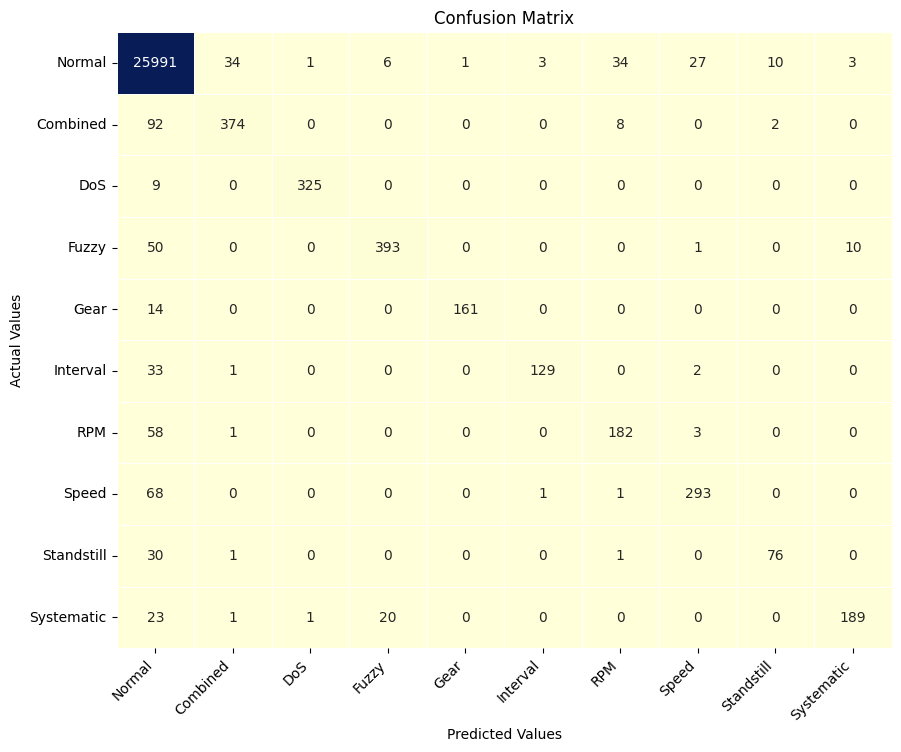

In [28]:
draw_confusion_matrix(cm, classes, save_dir='../pic/conf_matrix/confusion_matrix_ViT_transfer_can_ml_{}.png')